In [140]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score,confusion_matrix, silhouette_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.datasets import make_blobs


import warnings
warnings.filterwarnings("ignore")
os.chdir("/Users/yj.noh/Documents/GitHub")
print(os.getcwd())

/Users/yj.noh/Documents/GitHub


In [141]:
data = pd.read_csv("prj-ML-model-LT_OV30/modeling_data.csv", encoding = "cp949")
print(data.head())
print(data.shape)

            dlvry_id  reg_hour  ord_price  actual_dlvry_distance  pick_floor  \
0  20230827_9376QTJN        11      22500                   1274         1.0   
1  20230827_1765MBEB        17      15700                   2809         1.0   
2  20230827_0741UTNW        18      20400                   1961        -1.0   
3  20230827_6306VAVZ        19      16900                   1826         1.0   
4  20230827_5544DEBH        11      21000                   1184         2.0   

  pick_rgn2_nm pick_rgn3_nm pick_category pick_건물용도  dlvry_지상층수  dlvry_지하층수  \
0          서초구          잠원동       CHINESE      업무시설         NaN         NaN   
1          서초구          반포동         SNACK     일반음식점        19.0         5.0   
2          서초구          서초동     ZZIM_TANG       아파트         4.0         1.0   
3          서초구          방배동         ASIAN       아파트         5.0         0.0   
4          서초구          서초동          CAFE       NaN         4.0         1.0   

  dlvry_건물용도 day_of_week  is_holiday    기온  

In [142]:
# 건물 정보 없는 데이터 삭제 
filtered_data = data.dropna(subset=['pick_건물용도', 'dlvry_건물용도'])
print(filtered_data.shape) #44,644 
print(filtered_data['outcome'].value_counts()) # 38,816, 5,828 

(44644, 19)
outcome
0    38816
1     5828
Name: count, dtype: int64


In [143]:
print(filtered_data.isna().sum())

dlvry_id                    0
reg_hour                    0
ord_price                   0
actual_dlvry_distance       0
pick_floor                  0
pick_rgn2_nm                0
pick_rgn3_nm                0
pick_category               0
pick_건물용도                   0
dlvry_지상층수               5726
dlvry_지하층수               5726
dlvry_건물용도                  0
day_of_week                 0
is_holiday                  0
기온                          0
강수량                         0
dlvry_rgn2_nm               0
dlvry_rgn3_nm               0
outcome                     0
dtype: int64


In [144]:
print(filtered_data.dtypes)

dlvry_id                  object
reg_hour                   int64
ord_price                  int64
actual_dlvry_distance      int64
pick_floor               float64
pick_rgn2_nm              object
pick_rgn3_nm              object
pick_category             object
pick_건물용도                 object
dlvry_지상층수               float64
dlvry_지하층수               float64
dlvry_건물용도                object
day_of_week               object
is_holiday                  bool
기온                       float64
강수량                      float64
dlvry_rgn2_nm             object
dlvry_rgn3_nm             object
outcome                    int64
dtype: object


In [145]:
# dlvry_지하층수 음수로
# filtered_data['dlvry_지하층수'] = pd.to_numeric(filtered_data['dlvry_지하층수'], errors='coerce')
# filtered_data['dlvry_지상층수'] = pd.to_numeric(filtered_data['dlvry_지상층수'], errors='coerce')
# filtered_data['pick_floor'] = pd.to_numeric(filtered_data['pick_floor'], errors='coerce')

filtered_data['dlvry_지하층수'] = filtered_data['dlvry_지하층수'].apply(lambda x: -x)
#print(filtered_data.head())
print(filtered_data.isna().sum())

dlvry_id                    0
reg_hour                    0
ord_price                   0
actual_dlvry_distance       0
pick_floor                  0
pick_rgn2_nm                0
pick_rgn3_nm                0
pick_category               0
pick_건물용도                   0
dlvry_지상층수               5726
dlvry_지하층수               5726
dlvry_건물용도                  0
day_of_week                 0
is_holiday                  0
기온                          0
강수량                         0
dlvry_rgn2_nm               0
dlvry_rgn3_nm               0
outcome                     0
dtype: int64


## 1. 데이터 전처리


## 1-1. pick_건물용도/ dlvry_건물용도 : 개수 축소

In [146]:
print(filtered_data['pick_건물용도'].value_counts())

pick_건물용도
업무시설          14372
근린생활시설         7875
아파트            5367
일반음식점          5206
일반상점           3881
공동주택           3089
교육시설           1604
의료시설           1177
백화점             534
자동차관련시설         471
오피스텔            266
기타시설            210
숙박시설            174
대형판매점           141
위락시설            134
문화시설             87
종교시설             30
체육시설             16
위험물저장및처리시설       10
Name: count, dtype: int64


In [147]:
# 데이터 정리
values_to_replace = ['위락시설', '문화시설', '종교시설', '체육시설','위험물저장및처리시설', '자동차관련시설']
filtered_data['pick_건물용도'] = data['pick_건물용도'].replace(values_to_replace, '기타시설')
print(filtered_data['pick_건물용도'].value_counts())

pick_건물용도
업무시설      14372
근린생활시설     7875
아파트        5367
일반음식점      5206
일반상점       3881
공동주택       3089
교육시설       1604
의료시설       1177
기타시설        958
백화점         534
오피스텔        266
숙박시설        174
대형판매점       141
Name: count, dtype: int64


In [148]:
print(filtered_data['dlvry_건물용도'].value_counts())

dlvry_건물용도
공동주택          16952
아파트           13910
업무시설           7279
근린생활시설         1559
일반상점           1224
교육시설           1028
의료시설            758
일반음식점           557
숙박시설            459
공공시설            241
종교시설            127
교육연구시설          120
오피스텔            101
자동차관련시설          67
방송통신시설           53
기타시설             39
체육시설             36
백화점              36
위험물저장및처리시설       18
복지시설             16
문화시설             14
위락시설             12
복합몰               7
창고시설              6
수련시설              6
동식물시설             5
단독주택              5
운수시설              3
노유자시설             2
호텔                2
체력시설              1
공공용시설             1
Name: count, dtype: int64


In [149]:
value_counts = filtered_data['dlvry_건물용도'].value_counts()

threshold = 100
filtered_data['dlvry_건물용도'] = filtered_data['dlvry_건물용도'].apply(lambda x: '기타시설' if value_counts[x] <= threshold else x)

filtered_data['dlvry_건물용도'] = filtered_data['dlvry_건물용도'].replace('교육연구시설', '교육시설')
filtered_data['dlvry_건물용도'] = filtered_data['dlvry_건물용도'].replace('공공용시설', '공공시설')

print(filtered_data['dlvry_건물용도'].value_counts())

dlvry_건물용도
공동주택      16952
아파트       13910
업무시설       7279
근린생활시설     1559
일반상점       1224
교육시설       1148
의료시설        758
일반음식점       557
숙박시설        459
기타시설        329
공공시설        241
종교시설        127
오피스텔        101
Name: count, dtype: int64


## 1-2. dlvry_지상층수 /지하층수 : dlvry_건물용도 median 값 가져오기

In [150]:
median_values = filtered_data.dropna().groupby('dlvry_건물용도')[['dlvry_지상층수', 'dlvry_지하층수']].median()
mean_values = filtered_data.dropna().groupby('dlvry_건물용도')[['dlvry_지상층수', 'dlvry_지하층수']].mean()

print("Median Values:")
print(median_values)

print("\nMean Values:")
print(mean_values)


Median Values:
            dlvry_지상층수  dlvry_지하층수
dlvry_건물용도                        
공공시설               3.0        -0.0
공동주택               4.0        -1.0
교육시설               6.0        -1.0
근린생활시설             5.0        -1.0
기타시설               5.0        -2.0
숙박시설              10.0        -1.0
아파트               15.0        -1.0
업무시설              10.0        -3.0
오피스텔              15.0        -7.0
의료시설              10.0        -1.0
일반상점               4.0        -1.0
일반음식점              5.0        -1.0
종교시설               4.0        -3.0

Mean Values:
            dlvry_지상층수  dlvry_지하층수
dlvry_건물용도                        
공공시설          3.066390   -0.203320
공동주택          3.844208   -0.732086
교육시설          6.414397   -1.383268
근린생활시설        5.316228   -1.250160
기타시설          8.412698   -2.501587
숙박시설         10.838428   -2.397380
아파트          18.313515   -1.368009
업무시설         11.697593   -3.120231
오피스텔         15.000000   -6.118812
의료시설          9.507916   -1.928760
일반상점          5.041667   -

In [151]:
# na 값을 중앙값으로 채우기
filtered_data['dlvry_지상층수'].fillna(filtered_data['dlvry_건물용도'].map(median_values['dlvry_지상층수']), inplace=True)
filtered_data['dlvry_지하층수'].fillna(filtered_data['dlvry_건물용도'].map(median_values['dlvry_지하층수']), inplace=True)

print(filtered_data.describe())
print(filtered_data.columns)

           reg_hour      ord_price  actual_dlvry_distance    pick_floor  \
count  44644.000000   44644.000000           44644.000000  44644.000000   
mean      15.780866   27080.946757            1959.281538      0.748006   
std        3.745221   17994.351039            1156.483892      0.924460   
min        9.000000    5000.000000               1.000000     -1.000000   
25%       12.000000   16700.000000            1115.000000      1.000000   
50%       16.000000   22400.000000            1756.000000      1.000000   
75%       19.000000   31400.000000            2514.000000      1.000000   
max       23.000000  483000.000000            8003.000000      8.000000   

         dlvry_지상층수    dlvry_지하층수            기온           강수량       outcome  
count  44644.000000  44644.000000  44644.000000  44644.000000  44644.000000  
mean      10.028380     -1.476481     26.778833      0.609437      0.130544  
std        8.766227      1.608017      2.664765      3.162902      0.336905  
min        0

In [152]:
print(filtered_data.isna().sum())

dlvry_id                 0
reg_hour                 0
ord_price                0
actual_dlvry_distance    0
pick_floor               0
pick_rgn2_nm             0
pick_rgn3_nm             0
pick_category            0
pick_건물용도                0
dlvry_지상층수               0
dlvry_지하층수               0
dlvry_건물용도               0
day_of_week              0
is_holiday               0
기온                       0
강수량                      0
dlvry_rgn2_nm            0
dlvry_rgn3_nm            0
outcome                  0
dtype: int64


## 1-3.  pick_floor, dlvry_지상층수, dlvry_지하층수 

In [153]:
print(filtered_data['pick_floor'].value_counts())

pick_floor
 1.0    31450
-1.0     7548
 2.0     3810
 0.0     1363
 3.0      314
 4.0       85
 8.0       73
 6.0        1
Name: count, dtype: int64


In [154]:
print(filtered_data['dlvry_지하층수'].value_counts())

dlvry_지하층수
-1.0    24736
-0.0     9058
-2.0     3590
-3.0     1876
-4.0     1778
-5.0     1483
-6.0     1233
-7.0      674
-8.0      215
-9.0        1
Name: count, dtype: int64


In [155]:
print(filtered_data['dlvry_지상층수'].value_counts())
print(filtered_data['dlvry_지상층수'].describe())

dlvry_지상층수
4.0     9546
5.0     5935
3.0     4366
15.0    4286
6.0     2892
2.0     1796
12.0    1556
7.0     1408
20.0    1372
10.0    1270
13.0    1182
29.0     872
32.0     782
14.0     722
9.0      713
25.0     599
18.0     551
24.0     526
8.0      522
11.0     466
27.0     413
22.0     412
16.0     329
17.0     269
37.0     267
21.0     262
19.0     248
46.0     184
26.0     177
1.0      171
23.0     166
31.0     114
66.0      52
28.0      43
69.0      40
55.0      30
51.0      26
34.0      22
44.0      20
45.0      16
0.0        9
30.0       8
33.0       4
Name: count, dtype: int64
count    44644.000000
mean        10.028380
std          8.766227
min          0.000000
25%          4.000000
50%          6.000000
75%         15.000000
max         69.000000
Name: dlvry_지상층수, dtype: float64


In [156]:
def categorize_floor(value):
    if value < 0:
        return '지하'
    elif 0 <= value <= 5:
        return '저층'
    elif 6 <= value <= 10 :
        return '중층'
    elif 11 <= value <= 15 : 
        return '중상층'
    elif 16 <= value <= 29 :
        return '고층'
    elif 30 <= value <= 49 :
        return '준초고층'
    elif 50 <= value:
        return '초고층'

filtered_data['pick_floor'] = filtered_data['pick_floor'].apply(categorize_floor)
filtered_data['dlvry_지상층수'] = filtered_data['dlvry_지상층수'].apply(categorize_floor)

print(filtered_data['dlvry_지상층수'].value_counts())
print(filtered_data['pick_floor'].value_counts())

dlvry_지상층수
저층      21823
중상층      8212
중층       6805
고층       6239
준초고층     1417
초고층       148
Name: count, dtype: int64
pick_floor
저층    37022
지하     7548
중층       74
Name: count, dtype: int64


## 1-4. pick_rgn2_nm, dlvry_rgn2_nm, dlvry_rgn3_nm 정제

In [157]:
print(filtered_data['dlvry_rgn2_nm'].value_counts())
print(filtered_data['dlvry_rgn3_nm'].value_counts())

dlvry_rgn2_nm
서초구    32886
강남구     8302
동작구     2388
관악구      937
과천시      126
용산구        5
Name: count, dtype: int64
dlvry_rgn3_nm
서초동      13101
방배동       6994
반포동       6344
역삼동       2814
양재동       2729
잠원동       2043
사당동       1999
논현동       1832
우면동       1675
도곡동       1218
개포동        995
남현동        500
봉천동        427
대치동        418
신사동        417
삼성동        267
압구정동       161
흑석동        151
청담동        148
동작동        128
상도동         76
주암동         75
과천동         48
일원동         25
상도1동        18
본동          10
신림동         10
노량진동         6
자곡동          5
용산동6가        5
부림동          3
수서동          2
Name: count, dtype: int64


## 2. 데이터 전처리

In [158]:
print(filtered_data.shape) #44,644
print(filtered_data.info())

(44644, 19)
<class 'pandas.core.frame.DataFrame'>
Index: 44644 entries, 1 to 68026
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dlvry_id               44644 non-null  object 
 1   reg_hour               44644 non-null  int64  
 2   ord_price              44644 non-null  int64  
 3   actual_dlvry_distance  44644 non-null  int64  
 4   pick_floor             44644 non-null  object 
 5   pick_rgn2_nm           44644 non-null  object 
 6   pick_rgn3_nm           44644 non-null  object 
 7   pick_category          44644 non-null  object 
 8   pick_건물용도              44644 non-null  object 
 9   dlvry_지상층수             44644 non-null  object 
 10  dlvry_지하층수             44644 non-null  float64
 11  dlvry_건물용도             44644 non-null  object 
 12  day_of_week            44644 non-null  object 
 13  is_holiday             44644 non-null  bool   
 14  기온                     44644 non-null  float64


In [159]:
dataset = filtered_data[['reg_hour', 'ord_price','actual_dlvry_distance', 'pick_floor', 
                         'pick_category', 'pick_건물용도','dlvry_지상층수', 'dlvry_지하층수',
                         'dlvry_건물용도','day_of_week', 'is_holiday', '기온', 'dlvry_rgn2_nm', 'outcome'
                        ]]
dataset.isna().sum()
dataset.to_csv('prj-ML-model-LT_OV30/modeling_data_final.csv', index= False, encoding = "utf-8")

## 2-1. factor 변수 / one-hot-encoding

In [160]:
# category  
for col in ['reg_hour','pick_floor',  'pick_category', 'pick_건물용도','dlvry_지상층수','dlvry_건물용도',
            'day_of_week', 'is_holiday','dlvry_rgn2_nm', 'outcome' ] : 
    dataset[col] = dataset[col].astype('category')

print(dataset.dtypes)

reg_hour                 category
ord_price                   int64
actual_dlvry_distance       int64
pick_floor               category
pick_category            category
pick_건물용도                category
dlvry_지상층수               category
dlvry_지하층수                float64
dlvry_건물용도               category
day_of_week              category
is_holiday               category
기온                        float64
dlvry_rgn2_nm            category
outcome                  category
dtype: object


In [161]:
var = ['reg_hour','pick_floor',  'pick_category', 'pick_건물용도','dlvry_지상층수','dlvry_건물용도',
            'day_of_week', 'is_holiday','dlvry_rgn2_nm' ] 
encoder = OneHotEncoder()
onehot = pd.DataFrame(encoder.fit_transform(dataset[var]).toarray(), columns=encoder.get_feature_names_out(var), index = dataset.index)
dataset = pd.concat([onehot, dataset.drop(columns=var)], axis=1)

print(dataset.columns)

Index(['reg_hour_9', 'reg_hour_10', 'reg_hour_11', 'reg_hour_12',
       'reg_hour_13', 'reg_hour_14', 'reg_hour_15', 'reg_hour_16',
       'reg_hour_17', 'reg_hour_18', 'reg_hour_19', 'reg_hour_20',
       'reg_hour_21', 'reg_hour_22', 'reg_hour_23', 'pick_floor_저층',
       'pick_floor_중층', 'pick_floor_지하', 'pick_category_ASIAN',
       'pick_category_BAEKBAN', 'pick_category_BURGER', 'pick_category_CAFE',
       'pick_category_CHICKEN', 'pick_category_CHINESE',
       'pick_category_JAPANESE', 'pick_category_JOKBAL', 'pick_category_MEAT',
       'pick_category_PIZZA', 'pick_category_SNACK', 'pick_category_WESTERN',
       'pick_category_ZZIM_TANG', 'pick_건물용도_공동주택', 'pick_건물용도_교육시설',
       'pick_건물용도_근린생활시설', 'pick_건물용도_기타시설', 'pick_건물용도_대형판매점',
       'pick_건물용도_백화점', 'pick_건물용도_숙박시설', 'pick_건물용도_아파트', 'pick_건물용도_업무시설',
       'pick_건물용도_오피스텔', 'pick_건물용도_의료시설', 'pick_건물용도_일반상점', 'pick_건물용도_일반음식점',
       'dlvry_지상층수_고층', 'dlvry_지상층수_저층', 'dlvry_지상층수_준초고층', 'dlvry_지상층수_중상층',
      

## 3. train/test set split

In [162]:
outcome_counts = dataset['outcome'].value_counts()
train_set, test_set = train_test_split(dataset, test_size=0.25, stratify = dataset['outcome'], random_state=1234)

train_outcome_counts = train_set['outcome'].value_counts()
test_outcome_counts = test_set['outcome'].value_counts()

print(train_outcome_counts)
print(test_outcome_counts)

print(train_set.shape) #33483
print(test_set.shape) #11161

outcome
0    29112
1     4371
Name: count, dtype: int64
outcome
0    9704
1    1457
Name: count, dtype: int64
(33483, 83)
(11161, 83)


In [163]:
X_train = train_set.drop(columns=['outcome'])
y_train = train_set['outcome']

X_test = test_set.drop(columns=['outcome'])
y_test = test_set['outcome']

print(X_train.columns)

Index(['reg_hour_9', 'reg_hour_10', 'reg_hour_11', 'reg_hour_12',
       'reg_hour_13', 'reg_hour_14', 'reg_hour_15', 'reg_hour_16',
       'reg_hour_17', 'reg_hour_18', 'reg_hour_19', 'reg_hour_20',
       'reg_hour_21', 'reg_hour_22', 'reg_hour_23', 'pick_floor_저층',
       'pick_floor_중층', 'pick_floor_지하', 'pick_category_ASIAN',
       'pick_category_BAEKBAN', 'pick_category_BURGER', 'pick_category_CAFE',
       'pick_category_CHICKEN', 'pick_category_CHINESE',
       'pick_category_JAPANESE', 'pick_category_JOKBAL', 'pick_category_MEAT',
       'pick_category_PIZZA', 'pick_category_SNACK', 'pick_category_WESTERN',
       'pick_category_ZZIM_TANG', 'pick_건물용도_공동주택', 'pick_건물용도_교육시설',
       'pick_건물용도_근린생활시설', 'pick_건물용도_기타시설', 'pick_건물용도_대형판매점',
       'pick_건물용도_백화점', 'pick_건물용도_숙박시설', 'pick_건물용도_아파트', 'pick_건물용도_업무시설',
       'pick_건물용도_오피스텔', 'pick_건물용도_의료시설', 'pick_건물용도_일반상점', 'pick_건물용도_일반음식점',
       'dlvry_지상층수_고층', 'dlvry_지상층수_저층', 'dlvry_지상층수_준초고층', 'dlvry_지상층수_중상층',
      

In [164]:
# set.seed(1234)
# train_ratio = 0.75
# total_samples = dataset.shape[0]
# train_samples = int(train_ratio * total_samples)
# train_set = dataset[:train_samples]
# test_set = dataset[train_samples:]

# print(train_set.shape) #33483
# print(test_set.shape) #11161

## 4. numeric variables

In [165]:
num_vars = ['ord_price', 'actual_dlvry_distance', 'dlvry_지하층수', '기온']
scaler = MinMaxScaler()

X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

#print(X_train.head())
print(X_train.shape) #33483
print(X_test.shape) #11161

(33483, 82)
(11161, 82)


## 5. modeling - Logistic Regression

In [166]:
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

# 다중 공선성 확인
vif_result = calculate_vif(X_train)
print(vif_result)


                 Variable           VIF
0              reg_hour_9  7.466814e+07
1             reg_hour_10  2.722880e+08
2             reg_hour_11  6.452904e+05
3             reg_hour_12  5.288845e+05
4             reg_hour_13  1.358733e+06
..                    ...           ...
77      dlvry_rgn2_nm_용산구  4.240079e+11
78              ord_price  1.103896e+00
79  actual_dlvry_distance  1.106544e+00
80             dlvry_지하층수  1.734274e+00
81                     기온  1.492611e+00

[82 rows x 2 columns]


In [167]:
glm_1 = sm.GLM(y_train, X_train, family = sm.families.Binomial())
glm1_fit = glm_1.fit()
print(glm1_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                33483
Model:                            GLM   Df Residuals:                    33410
Model Family:                Binomial   Df Model:                           72
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10472.
Date:                Mon, 18 Sep 2023   Deviance:                       20945.
Time:                        14:05:15   Pearson chi2:                 3.41e+04
No. Iterations:                   100   Pseudo R-squ. (CS):             0.1387
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
reg_hour_9                

In [180]:
y_pred = glm1_fit.predict(X_test)

threshold = 0.5 # cut-off 값 
y_pred_binary = (y_pred > threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

print("\nConfusion Matrix:")
print(conf_matrix)
print("\nAccuracy:", accuracy) #0.87
print("Sensitivity (True Positive Rate):", sensitivity) # 0.18
print("Specificity (True Negative Rate):", specificity) # 0.98

test = conf_matrix[1,1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
print(test)


Confusion Matrix:
[[9551  153]
 [1189  268]]

Accuracy: 0.8797598781471194
Sensitivity (True Positive Rate): 0.18393960192175704
Specificity (True Negative Rate): 0.9842333058532564
0.6365795724465558


In [169]:
print(y_pred.shape) #11,161                             

(11161,)


In [170]:
# logit_model = LogisticRegression(penalty = 'none')
# cv_scores = cross_val_score(logit_model, X_train, y_train, cv=5, scoring='accuracy')
# mean_cv_accuracy = cv_scores.mean()
# print("Cross-Validation Mean Accuracy:", mean_cv_accuracy)

# logit_model.fit(X_train, y_train)
# print("Model Coefficients:", logit_model.coef_)


In [171]:
# X_train = sm.add_constant(X_train) 
# logit_model = sm.Logit(y_train, X_train)
# result = logit_model.fit()

# print(result.summary())

# X_test = sm.add_constant(X_test) 
# y_pred = result.predict(X_test)  

# y_pred_binary = (y_pred > 0.5).astype(int)

# conf_matrix = confusion_matrix(y_test, y_pred_binary)
# accuracy = accuracy_score(y_test, y_pred_binary)
# sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
# specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

# print("\nConfusion Matrix:")
# print(conf_matrix)
# print("\nAccuracy:", accuracy)
# print("Sensitivity (True Positive Rate):", sensitivity)
# print("Specificity (True Negative Rate):", specificity)


In [172]:
# glm_2 = LogisticRegression(penalty='none')
# glm_2.fit(X_train, y_train)

# variable_names = X_train.columns
# coef = glm_2.coef_[0]

# coef_table = pd.DataFrame({'Variable': variable_names, 'Coefficient': coef})

# logit_model = sm.Logit(y_train, X_train)
# result = logit_model.fit()
# p_values = result.pvalues
# coef_table['p-value'] = p_values

# print(coef_table)
# pred_glm = glm_2.predict(X_test)
# class_report = classification_report(y_test, pred_glm)
# print(class_report)

## 6. clustering

In [173]:
def visualize_silhouette_scores(data, method='kmeans', param_init='random', param_n_init=10, param_max_iter=300):
    clusters_range = range(2, 15)
    results = []

    for i in clusters_range:
        if method == 'kmeans':
            clusterer = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        elif method == 'agglomerative':
            clusterer = AgglomerativeClustering(n_clusters=i)
        else:
            raise ValueError("Invalid method. Choose 'kmeans' or 'agglomerative'.")

        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    
    plt.figure()
    sns.heatmap(pd.pivot_table(result, index="n_clusters", values="silhouette_score"),annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.title(f"Silhouette Scores for {method.capitalize()} Clustering")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.show()


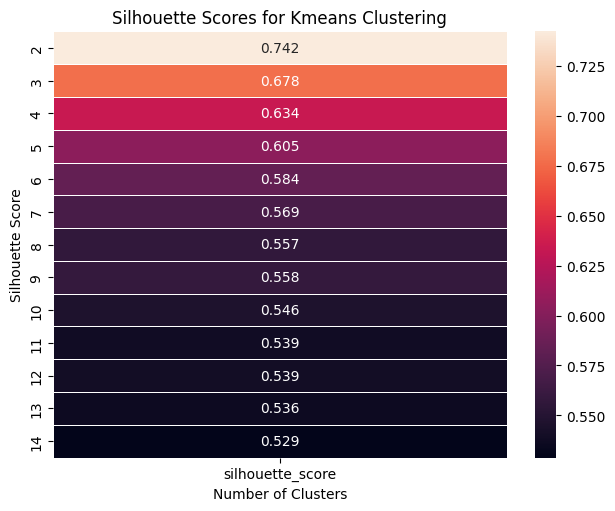

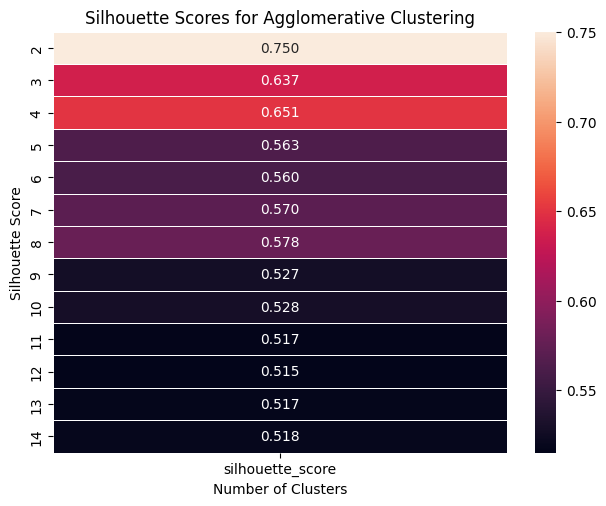

In [174]:
data  = y_pred.to_numpy().reshape(-1, 1)

visualize_silhouette_scores(data, method='kmeans')
visualize_silhouette_scores(data, method='agglomerative')

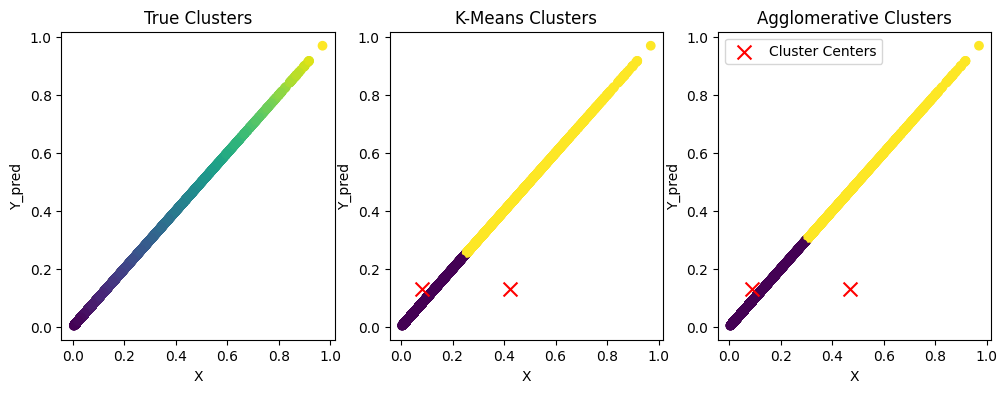

In [175]:
X = y_pred.to_numpy().reshape(-1, 1)

n = 2

kmeans = KMeans(n_clusters = n )
kmeans_clusters = kmeans.fit_predict(X)

agglomerative = AgglomerativeClustering(n_clusters = n )
agglomerative_clusters = agglomerative.fit_predict(X)

kmeans_cluster_centers = kmeans.cluster_centers_
agg_cluster_centers = np.array([X[agglomerative_clusters == i].mean() for i in range(2)])

kmeans_clusters = kmeans_clusters
agglomerative_clusters = agglomerative_clusters

# 데이터 시각화
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.scatter(X, y_pred, c=y_pred, cmap='viridis')
plt.title('True Clusters')
plt.xlabel('X')
plt.ylabel('Y_pred')

plt.subplot(132)
plt.scatter(X, y_pred, c=kmeans_clusters, cmap='viridis')
plt.scatter(kmeans_cluster_centers, [y_pred.mean()] * len(kmeans_cluster_centers), c='red', marker='x', s=100, label='Cluster Centers')
plt.title('K-Means Clusters')
plt.xlabel('X')
plt.ylabel('Y_pred')

plt.subplot(133)
plt.scatter(X, y_pred, c=agglomerative_clusters, cmap='viridis')
plt.scatter(agg_cluster_centers, [y_pred.mean()] * len(agg_cluster_centers), c='red', marker='x', s=100, label='Cluster Centers')
plt.title('Agglomerative Clusters')
plt.xlabel('X')
plt.ylabel('Y_pred')

plt.legend()
plt.show()


In [176]:
kmeans_silhouette_score = silhouette_score(X, kmeans_clusters)
agglomerative_silhouette_score = silhouette_score(X, agglomerative_clusters)

print(f"K-Means Silhouette Score: {kmeans_silhouette_score:.2f}")
print(f"Agglomerative Silhouette Score: {agglomerative_silhouette_score:.2f}")


K-Means Silhouette Score: 0.74
Agglomerative Silhouette Score: 0.75
